In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA

In [2]:
data_gas = pd.read_csv('Geochemistry Data/CNS_gas_train.csv')

In [3]:
data_gas.drop(0, axis=0, inplace=True)

In [4]:
data_gas = data_gas.reset_index(drop=True)

In [5]:
r_s = int(len(data_gas['WELL_NAME'].unique())/100*70)
well_train = np.random.choice(data_gas['WELL_NAME'].unique(), r_s, False)

In [6]:
df_train = data_gas[data_gas['WELL_NAME'].isin(well_train)]

In [7]:
df_test = data_gas[~data_gas['WELL_NAME'].isin(well_train)]

predict "GAS_C1, GAS_C2, GAS_C3, GAS_IC4, GAS_NC4, GAS_IC5, GAS_NC5 "

In [8]:
col_x = ['WH_LAT', 'WH_LONG', 'SH_DEPTH_TOP_FT', 'SH_DEPTH_BOT_FT', 'WH_TD_M', 'WH_DR_ELEV_M',
'C2_UNSAT', 'C3_UNSAT','CSIA_CONC_C1', 'CSIA_NC1', 'CSIA_NC2', 'CSIA_NC3', 'CSIA_IC4',
'CSIA_NC4', 'CSIA_IC5', 'CSIA_NC5']
col_y = ['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']

In [9]:
y_train = df_train.loc[:, col_y].astype(float)
y_test = df_test.loc[:, col_y].astype(float)

feat_full_list = []
for col in data_gas.columns:
    if col not in y.columns:
        feat_full_list.append(col)

X = data_gas.loc[:, feat_full_list]

num_cols = []
for i in range(len(X.columns)):
    if X.count()[i] > 1000:
        num_cols.append(X.count().index[i])

In [10]:
X_train = df_train.loc[:, col_x]
X_test = df_test.loc[:, col_x]

In [11]:
X_train['WH_LAT'] = X_train['WH_LAT'].fillna(X_train['WH_LAT'].median()).astype(float)
X_test['WH_LAT'] = X_test['WH_LAT'].fillna(X_test['WH_LAT'].median()).astype(float)

In [12]:
X_train[X_train['WH_LONG'] == 'World Geodetic System 1984'].index

Int64Index([1704], dtype='int64')

In [13]:
X_train.loc[1704, 'WH_LONG'] = 1.953815702

In [14]:
X_train['WH_LONG'] = X_train['WH_LONG'].fillna(X_train['WH_LONG'].median()).astype(float)
X_test['WH_LONG'] = X_test['WH_LONG'].fillna(X_test['WH_LONG'].median()).astype(float)

In [15]:
X_train = X_train.fillna(X_train.median())
X_train = X_train.astype(float)

X_test = X_test.fillna(X_test.median())
X_test = X_test.astype(float)

In [17]:
# Baseline
from sklearn.dummy import DummyRegressor
bl = DummyRegressor(strategy='mean')
bl.fit(X_train, y_train)
y_1 = bl.predict(X_test)
print(mean_squared_error(y_test, y_1))

39.26177703584541


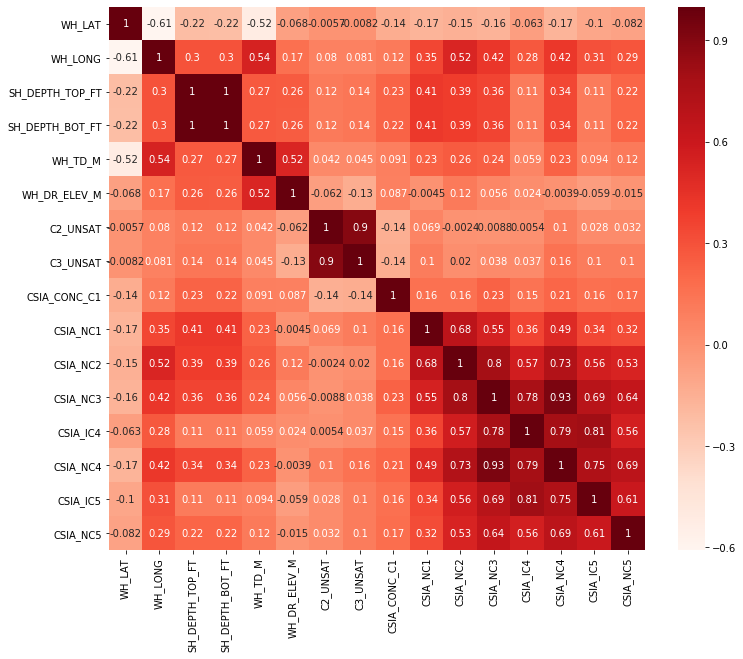

In [263]:
# Corr within selected features
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
X_train = pd.concat([X_train, X_test], axis=0)
y_train = pd.concat([y_train, y_test], axis=0)

In [30]:
df_test = pd.read_csv('Geochemistry Data/CNS_gas_test.csv')

In [31]:
X_test = df_test[col_x].fillna(df_test[col_x].median())

In [32]:
X_norm_train = normalize(X_train)
X_norm_test = normalize(X_test)
X_stand_train = scale(X_train)
X_stand_test = scale(X_test) 

In [33]:
# Ver_1 (Stacked models)

params1 = {'n_estimators': 100,
          'max_depth': 9,
          'max_features': 10,
          'bootstrap': True,
          'random_state': 42}

params2 = {'n_estimators': 15,
            'max_depth': 26,
            'max_features': 0.8,    
            'random_state': 42}

pca = PCA(n_components=6)
X_1 = pca.fit_transform(X_train)
X_2 = pca.transform(X_test)

model1 = LinearRegression()
model1.fit(X_1, y_train)
pred1 = model1.predict(X_2)

model2 = RandomForestRegressor(**params1)
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)

model3 = KNeighborsRegressor(n_neighbors = 5)
model3.fit(X_stand_train, y_train)
pred3 = model3.predict(X_stand_test) 

model4 = ExtraTreesRegressor(**params2)
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test) 

# print(mean_squared_error(y_test, (pred1+pred2+pred3+pred4)/4))

res = pd.DataFrame((pred1+pred2+pred3+pred4)/4)
res.columns = y_train.columns
# res.to_csv('test_pred.csv', index=False)

In [34]:
for col in col_y:
    df_test[col] = res[col]

In [37]:
df_test.to_csv('CNS_gas_test.csv', index=False)

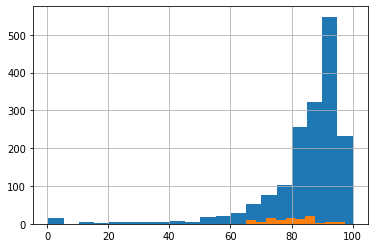

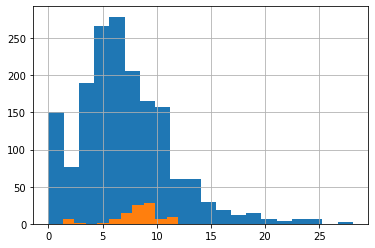

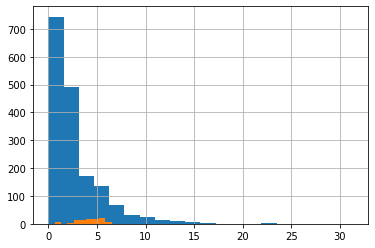

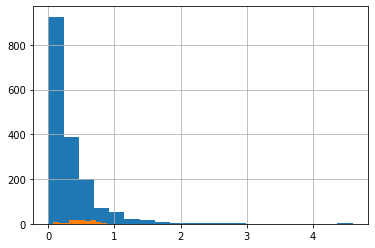

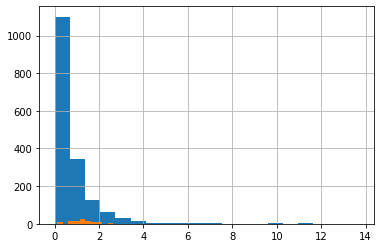

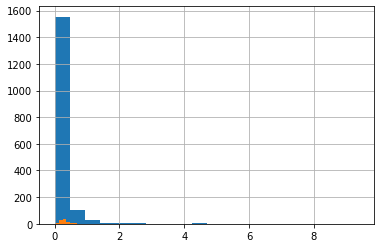

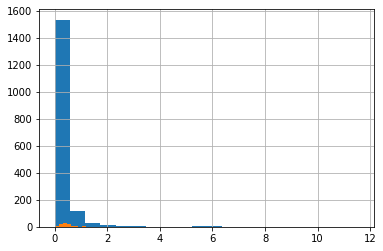

In [29]:
# Check target distributions
for col in res.columns:
    y_train[col].hist(bins=20)
    res[col].hist()
    plt.show()

In [336]:
x = dict(zip(X_test.columns, model2.feature_importances_))
{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

{'CSIA_NC1': 0.1271813669394584,
 'WH_LONG': 0.10816552913268343,
 'WH_TD_M': 0.10323868459056885,
 'C3_UNSAT': 0.07136373722558927,
 'SH_DEPTH_TOP_FT': 0.06930325053499853,
 'SH_DEPTH_BOT_FT': 0.06405726604549312,
 'CSIA_CONC_C1': 0.06221481848989655,
 'CSIA_NC2': 0.06212693277031311,
 'WH_LAT': 0.05590030057253859,
 'C2_UNSAT': 0.05435340103603676,
 'CSIA_NC4': 0.045403018221176115,
 'CSIA_NC5': 0.04480122932127545,
 'CSIA_NC3': 0.04041428187766047,
 'WH_DR_ELEV_M': 0.03743948968689895,
 'CSIA_IC4': 0.030831591279159402,
 'CSIA_IC5': 0.0232051022762531}

In [141]:
# Version 2 (chain-prediction)

params1 = {'n_estimators': 100,
          'max_depth': 20,
          'max_features': 10,
          'bootstrap': True,
          'random_state': 42}

params2 = {'n_estimators': 80,
          'max_depth': 20,
          'max_features': 5,
          'bootstrap': True,
          'random_state': 42}


pca = PCA(n_components=5)
X_1 = pca.fit_transform(X_train)
X_2 = pca.transform(X_test)

model1 = LinearRegression()
model1.fit(X_1, y_train.iloc[:, 2:])
pred1 = model1.predict(X_2)

model2 = RandomForestRegressor(**params1)
model2.fit(X_train, y_train.iloc[:, 2:])
pred2 = model2.predict(X_test)

# print(mean_squared_error(y_test.iloc[:, 2:], (pred1+pred2)/2))

model3 = RandomForestRegressor(**params2)
model3.fit(pd.concat([X_train, y_train.iloc[:, 2:]], axis=1), y_train.iloc[:, [0,1]])
pred3 = model3.predict(pd.concat([X_test.reset_index(drop=True), pd.DataFrame((pred1+pred2)/2).reset_index(drop=True)], axis=1))
print(mean_squared_error(y_test.iloc[:, [0,1]], pred3))

132.51457943902358
